In [2]:
import numpy as np
import pandas as pd
from time import strptime
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import GradientBoostingClassifier as gbdt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

In [3]:
#loading data 
train_data = "./Dataset/Train.csv"
test_data = "./Dataset/Test.csv"
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

# Overview of Data

In [4]:
train_df.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1


In [5]:
test_df.head(3)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34


* Train data contains:
        * INCIDENT_ID
        * DATE
        * 15 numerical variables from X_1 to X_15
        * MULTIPLE_OFFENCE(target)
* Test contains
        * Incident_ID
        * DATE
        * 15 numerical variables from X_1 to X_15

In [6]:
train_df.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
count,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23674.000000,23856.000000,23856.000000,23856.000000,23856.000000
mean,0.483778,24.791206,24.637450,4.276744,2.455609,6.154175,4.876509,0.972460,4.924128,1.244802,206.954519,0.974064,85.237383,72.674296,33.464747,0.955231
std,1.439738,15.240231,15.135093,2.944672,1.963095,4.471756,3.881931,1.453144,1.362625,1.119301,93.033348,1.167725,27.597226,43.297320,8.386834,0.206800
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000,1.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000,1.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000,1.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,99.000000,6.000000,90.000000,332.000000,90.000000,116.000000,142.000000,50.000000,1.000000


In [7]:
test_df.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
count,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15903.000000,15776.000000,15903.000000,15903.000000,15903.000000
mean,0.468088,24.722631,24.575049,4.284223,2.448469,6.084890,4.862605,0.986732,4.908759,1.241212,206.954097,0.972236,85.191096,72.218575,33.422625
std,1.412112,15.228841,15.127451,2.974584,1.963372,4.451117,3.854550,1.471274,1.374677,0.841804,93.107783,0.876669,27.493192,43.438227,8.314284
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,50.000000,6.000000,40.000000,332.000000,40.000000,117.000000,142.000000,50.000000


* Both test and train data have similar distributions, and have similar
         mean, std, min, max values

In [8]:
train_df["X_12"].isnull().sum()

182

In [9]:
test_df["X_12"].isnull().sum()

127

* Let's check for missing values in data
        * By observing train and test data "describe()", we found feature X_12 contains less "count"
        * feature X_12 contains 182 missing values in train data
        * feature X_12 contains 127 missing values in test data

In [10]:
target = train_df["MULTIPLE_OFFENSE"]

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

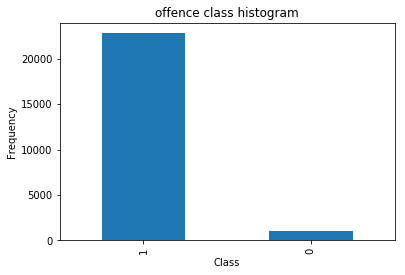

In [12]:
pd.value_counts(target).plot(kind='bar')
plt.title('offence class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
target.value_counts()

* This is a imbalanced dataset 
        * 22788 data points are labled as 1
        * 1068 data points are labled as 0

In [13]:
train = train_df.iloc[:, 1:17]

In [14]:
def conv_month_to_num(month_name):
    return str(strptime(month_name, "%b").tm_mon)
def conv_date(date_data):
    date_int = []
    for date in date_data["DATE"]:
        date_lst = date.split("-")
        month_num = conv_month_to_num(date_lst[1])
        if len(month_num) == 1:
            month_num = "0" + month_num
        final_date = date_lst[0] + month_num + date_lst[2]
        date_int.append(int(final_date))
    return date_int
#     train_df["DATE"] = date_int

In [15]:
train["DATE"] = conv_date(train)
test_df["DATE"] = conv_date(test_df)

* Inside date we have month name, so we need to convert month name to month num
* Then converting date format from string format (dd-month_name-yy) to int format (ddmmyy)

# Correlations b/w features

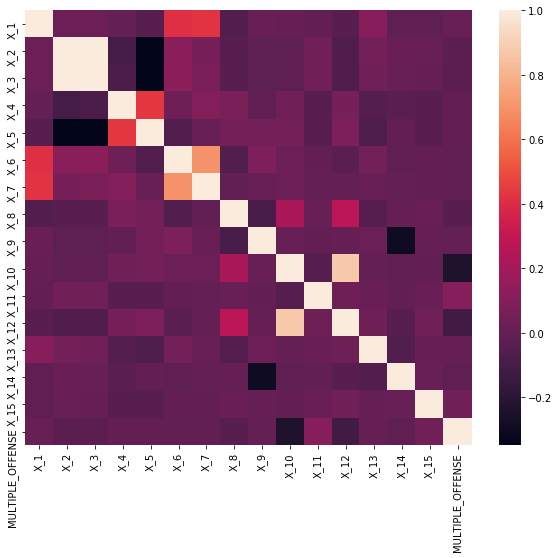

In [16]:
f, ax = plt.subplots(figsize=(10, 8))
corr = train_df.corr(method = "pearson")
# print(corr)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


* X_2, X_3 are very highly correlated
* (x_6, x_7), (x_10, x_12) are highly correlated
* (X_4, x_5), (x_1, x_6), (x_1, X_7) modeately correlated

# Median based Imputations and Duplicate data Removal

In [17]:
train["X_12"] = train_df['X_12'].fillna(train_df.groupby('MULTIPLE_OFFENSE')['X_12'].transform('median'))
test_df["X_12"].fillna((train_df["X_12"].median()), inplace = True)

* Filling missed values with mean 
        * train data is filled with mean according to the class label
        * test data is filled with mean

In [18]:
target.value_counts()

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [19]:
train["MULTIPLE_OFFENSE"] = target
print(train[train.duplicated(keep = "first") == True].shape)
train.drop_duplicates(keep="first", inplace=True)

(5, 17)


In [20]:
target = train["MULTIPLE_OFFENSE"]
train = train.drop(["MULTIPLE_OFFENSE"], axis = 1)

# Synthetic Data Creation for minority class

In [27]:
sm = SMOTE(random_state=2)
X, Y = sm.fit_sample(train, target)
Y.value_counts()

1    22783
0    22783
Name: MULTIPLE_OFFENSE, dtype: int64

In [28]:
X["MULTIPLE_OFFENSE"] = Y

* This is a imbalanced dataset, It encourages our classifier to make biased predictions
* Creating synthetic data for minority class using "SMOTE"
* Now data is balanced

* Finding and Removind Duplicated Data
        * There are 292 duplicated data points are present in the data
        * There are 3 duplicates which contains label 1
        * There are 287 duplicates which contains label 0

# EDA

<Figure size 432x288 with 0 Axes>

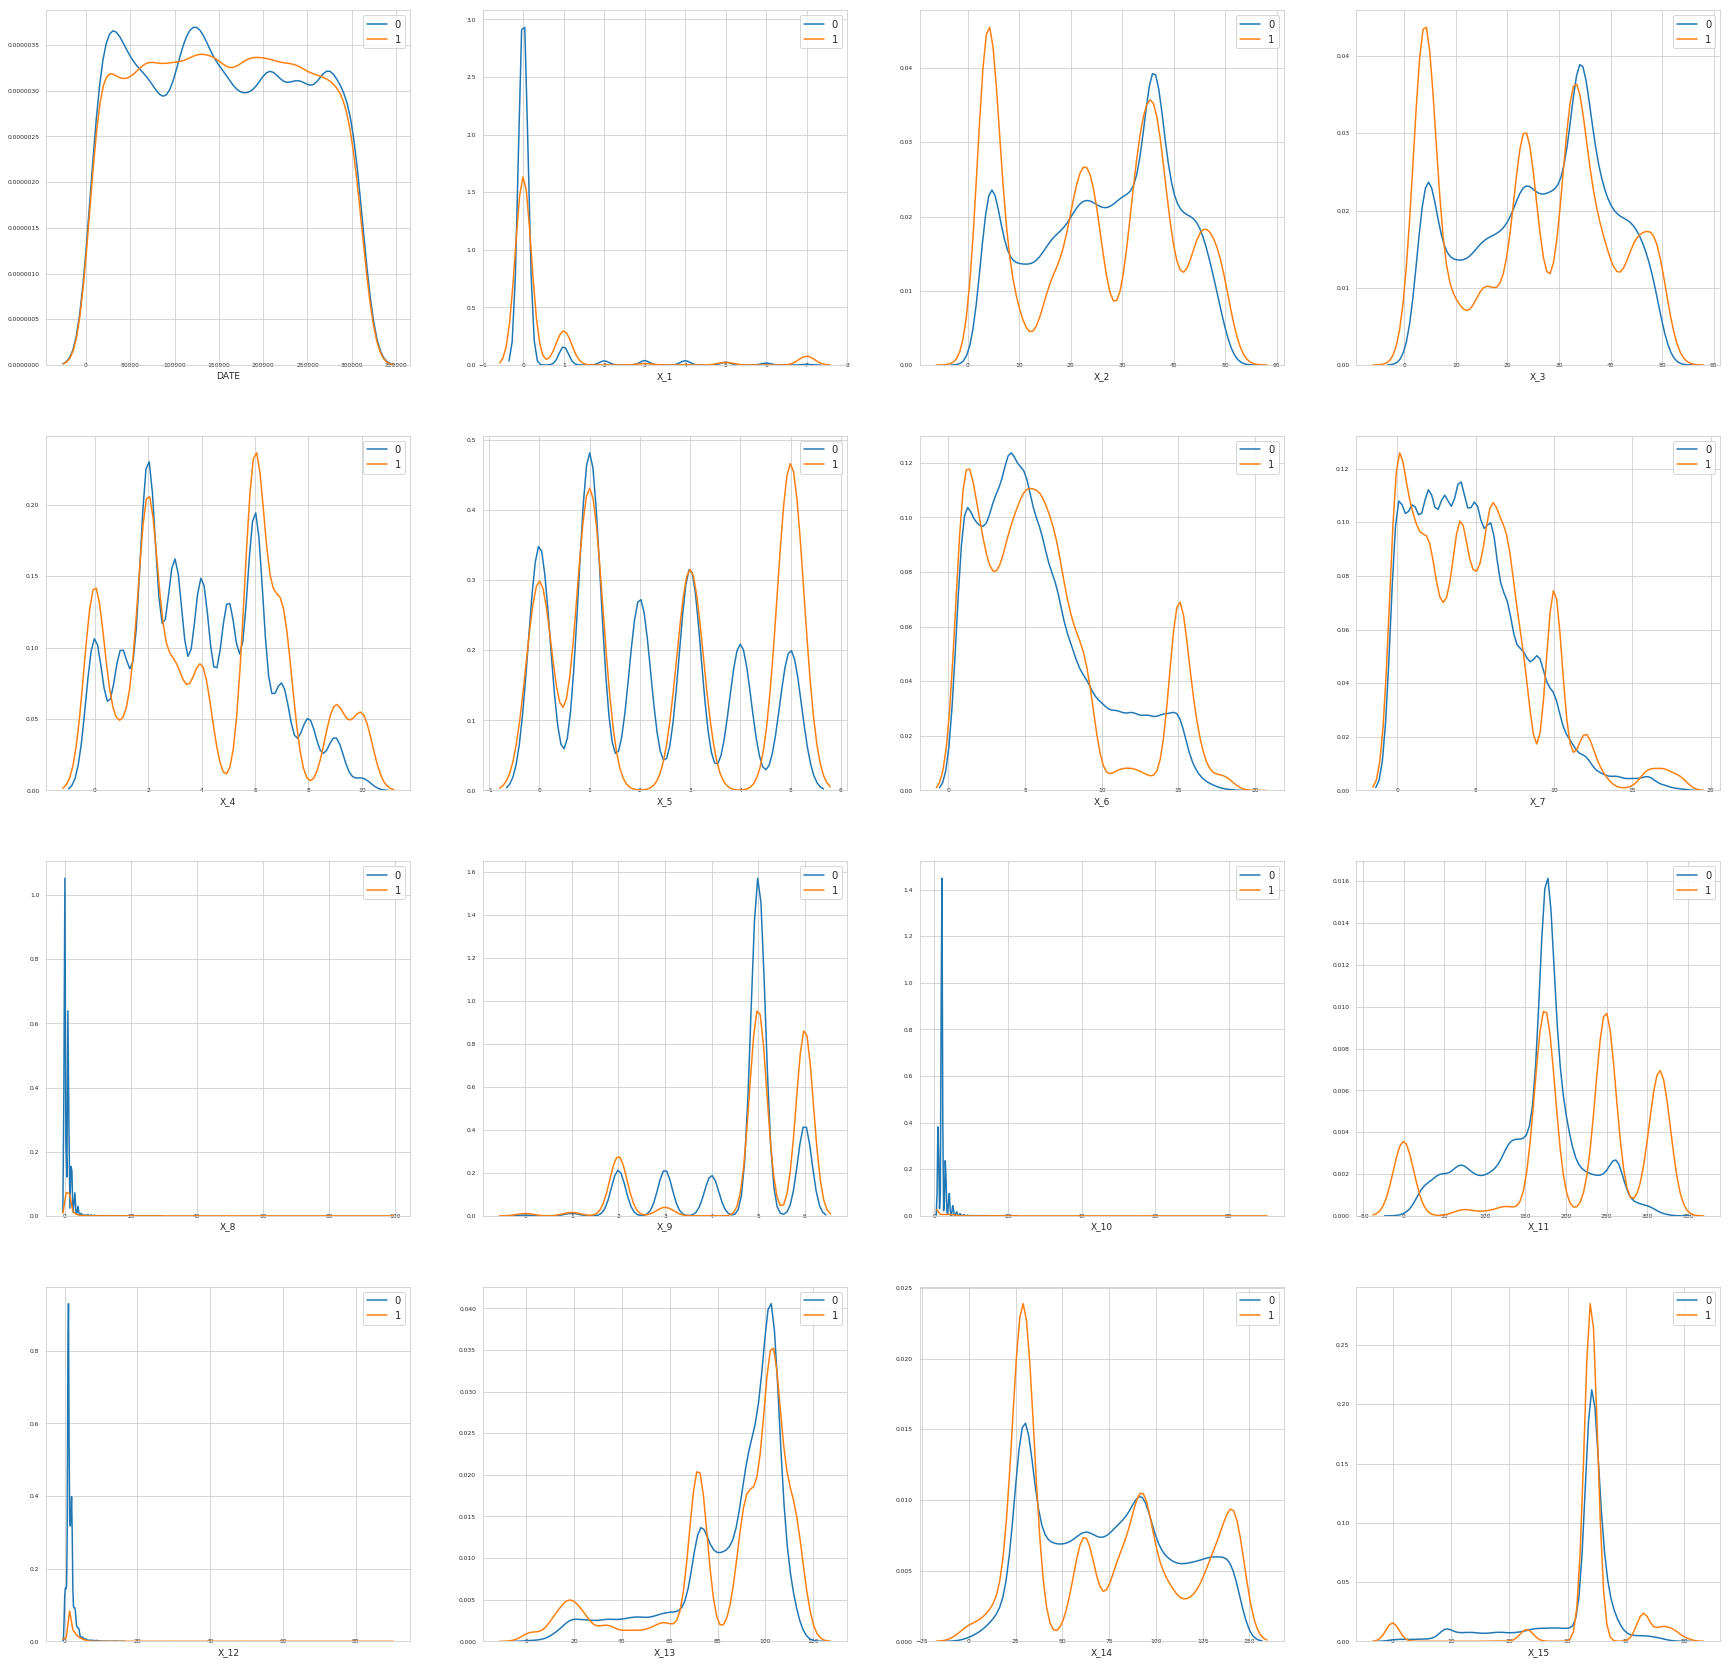

In [542]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(30,30))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

    
t0 = X.loc[X['MULTIPLE_OFFENSE'] == 0]
t1 = X.loc[X['MULTIPLE_OFFENSE'] == 1]
features = X.columns.values[:16]
plot_feature_distribution(t0, t1, '0', '1', features)


* Data distributions of positive and negative labeled training data.
* DATE feature following a ~uniform distribution
* features like "X_1, X_8, X_10, X_12" are right skewed
* X_2, X_8, X_10, X_12 have long tails

train_data


<Figure size 432x288 with 0 Axes>

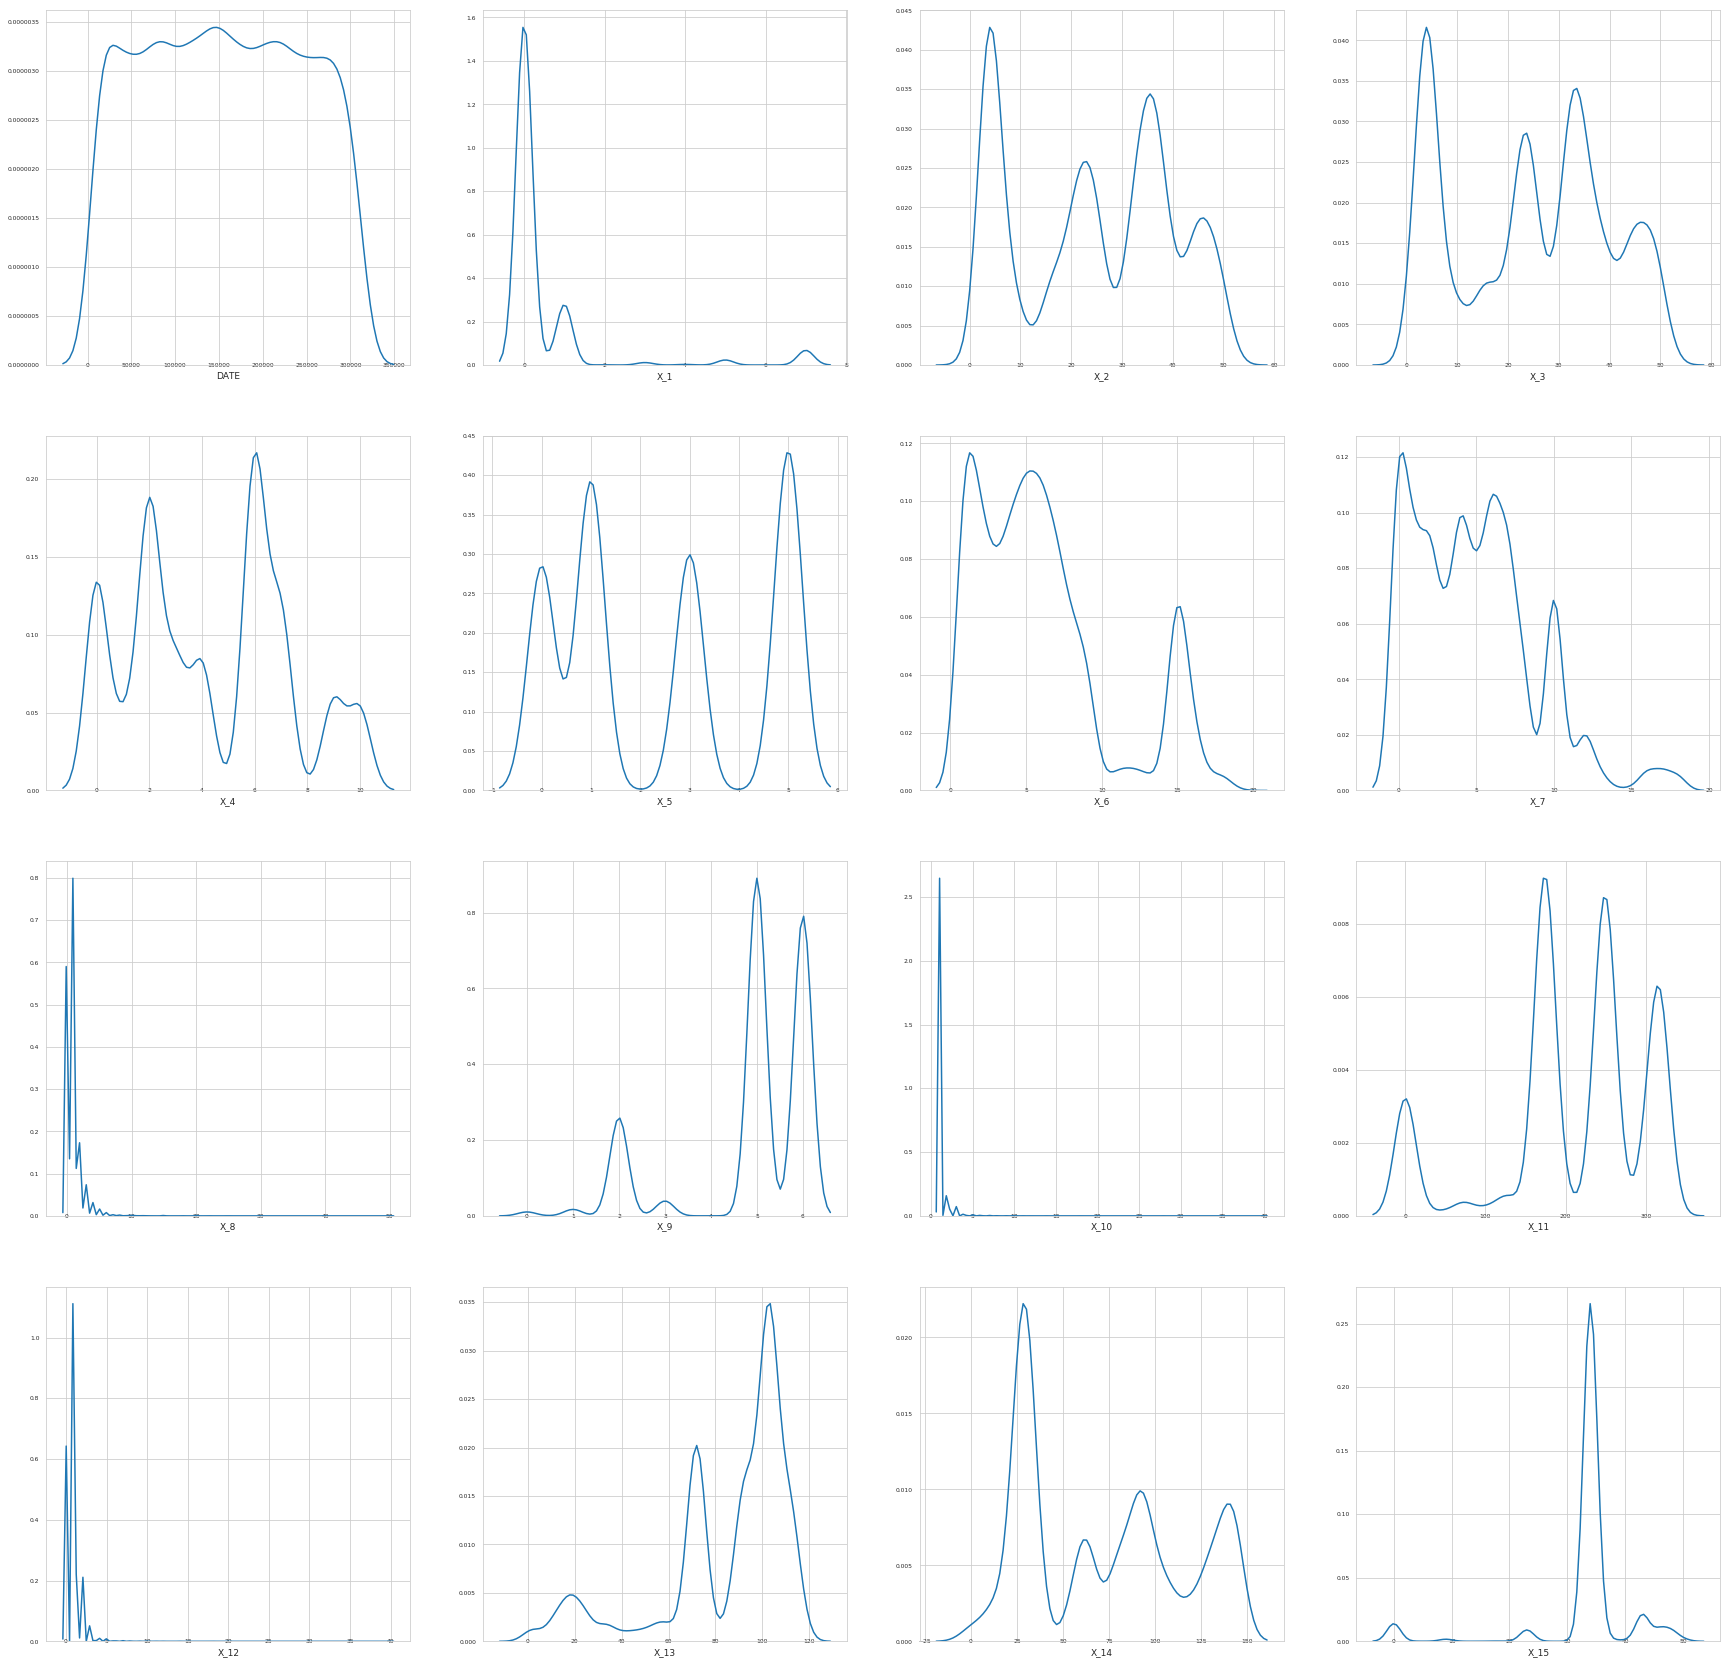

test_data


<Figure size 432x288 with 0 Axes>

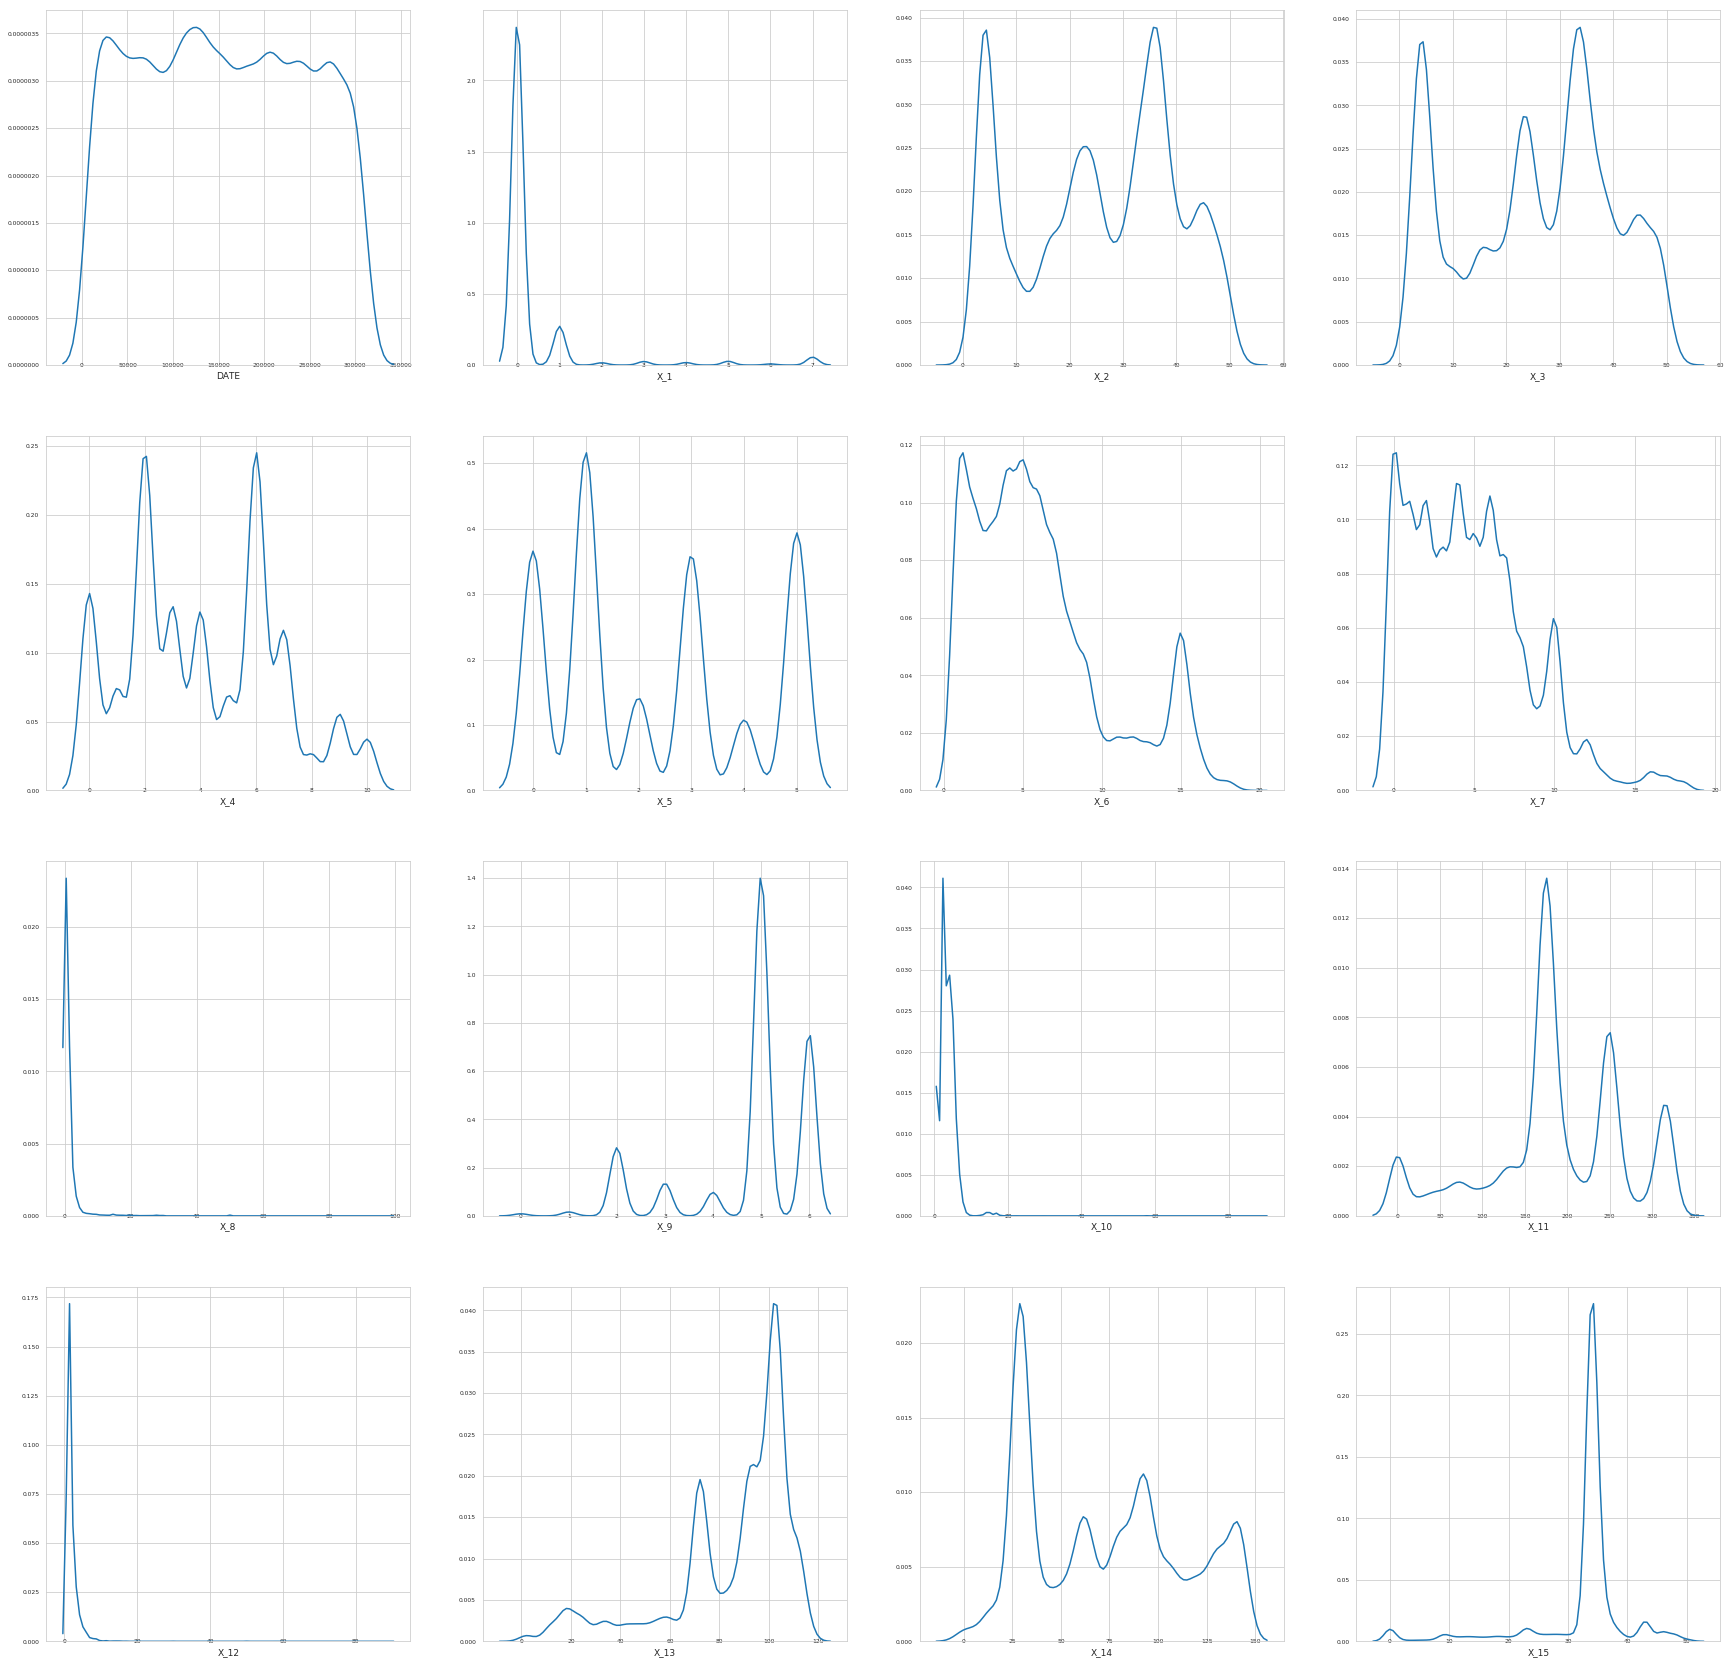

In [543]:
def plot_distrib(df1, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(30,30))
    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        sns.distplot(df1[feature], hist=False)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();
print("train_data")
plot_distrib(test_df, features)
print("test_data")
plot_distrib(X, features)

* Train and Test features are following similar feature distributions
* We can clearly see that feature "X_2, X_3" having same distribution and hence they have high collreation


<Figure size 432x288 with 0 Axes>

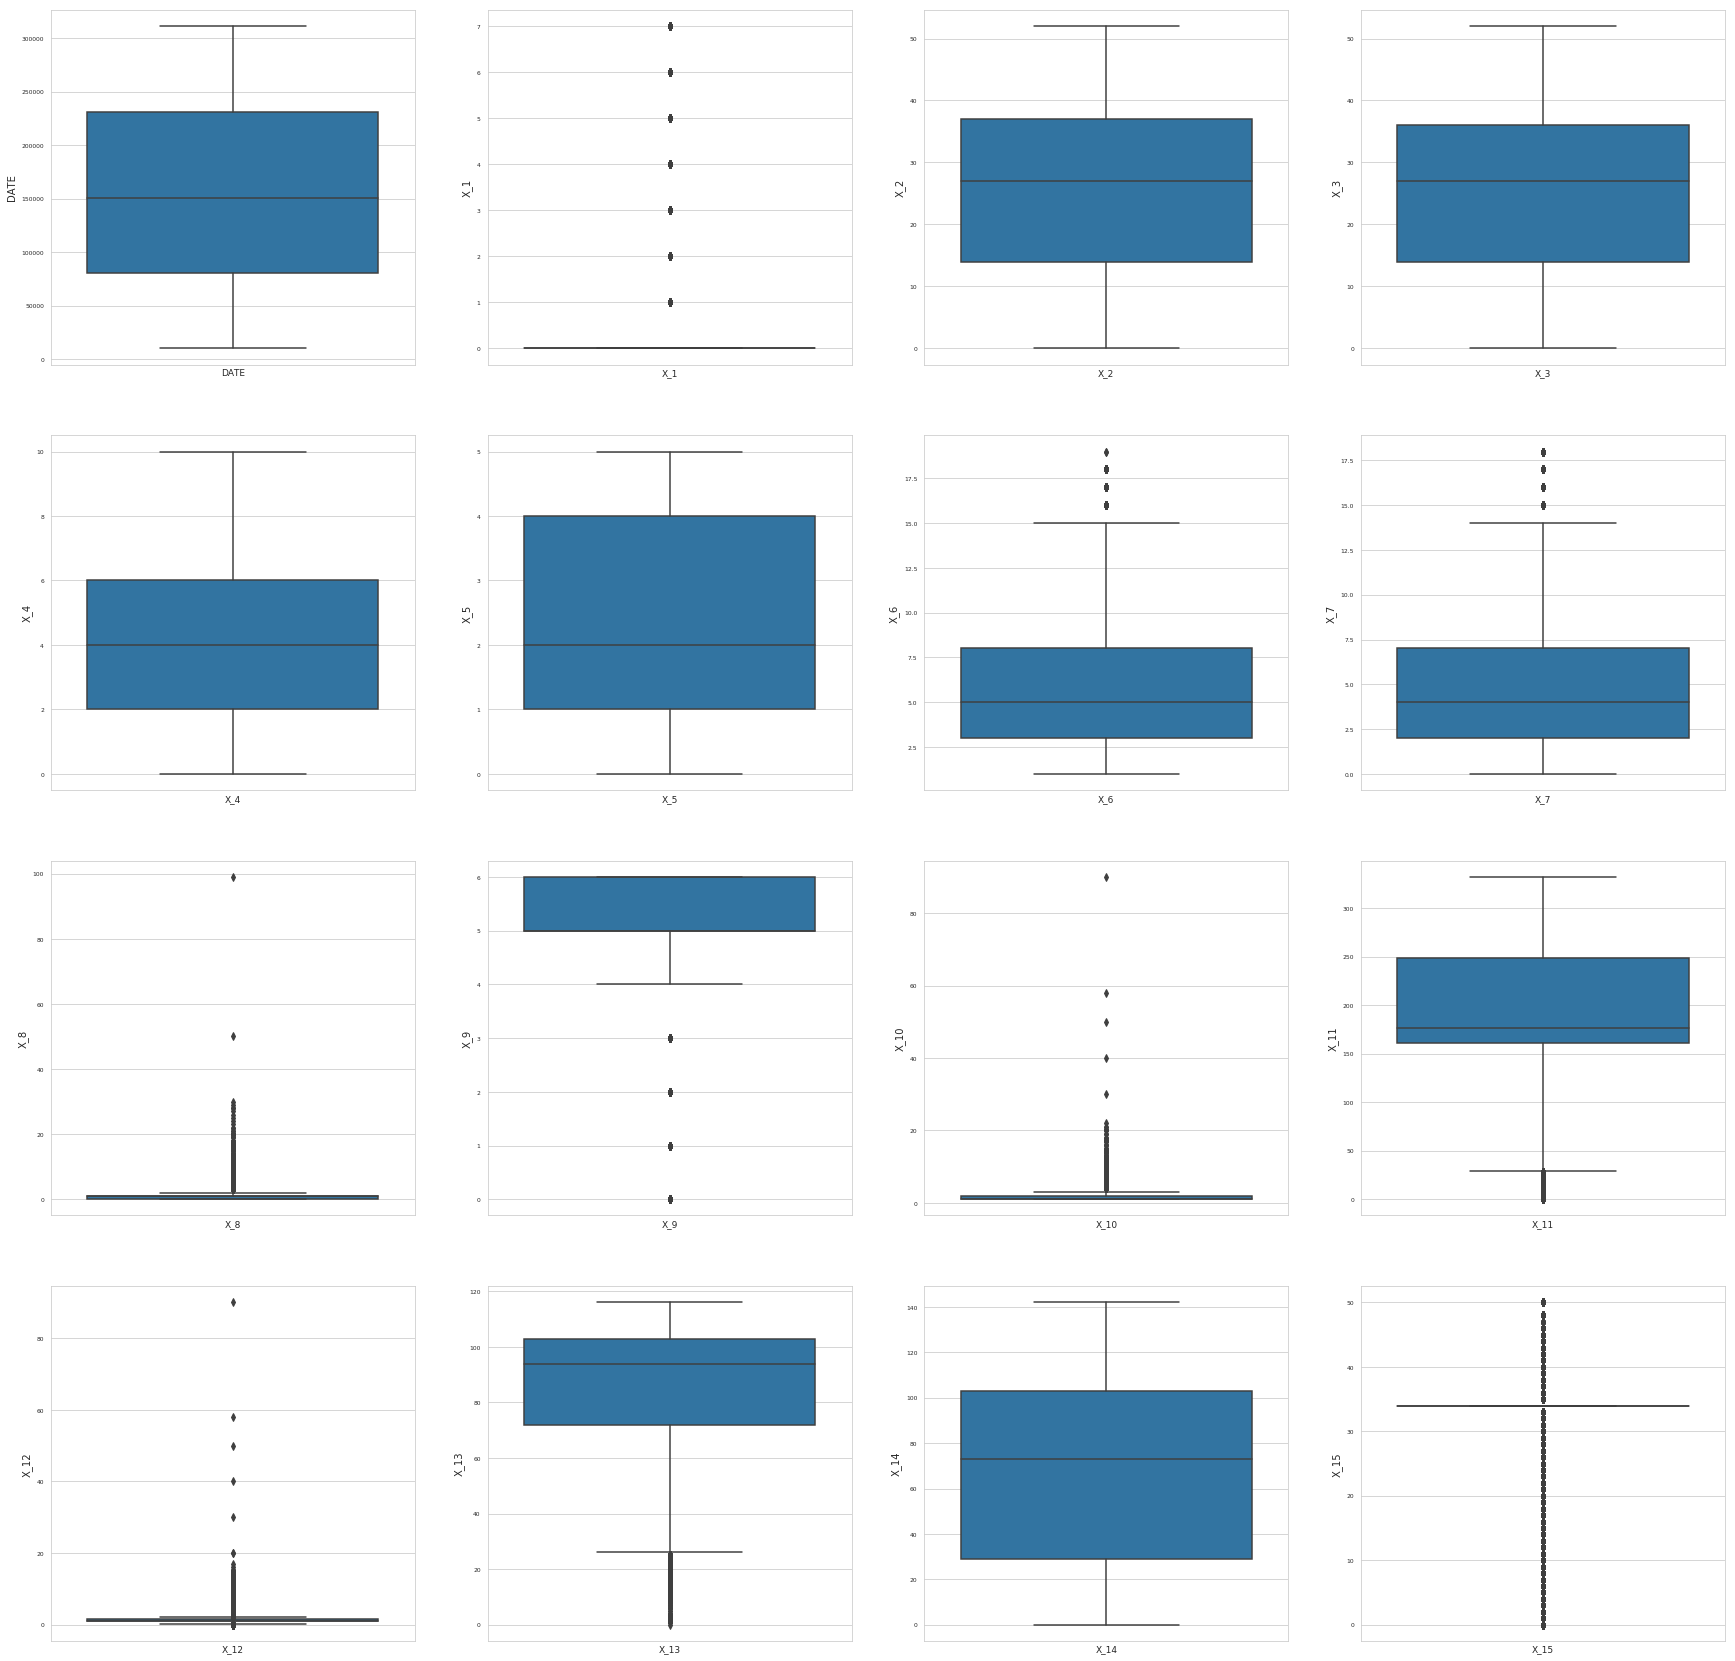

In [544]:
def plot_feature_distribution(df, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(30,30))
    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        sns.boxplot(df[feature], orient = 'v')
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();
    
features = X.columns.values[:16]
plot_feature_distribution(X, features)

<Figure size 432x288 with 0 Axes>

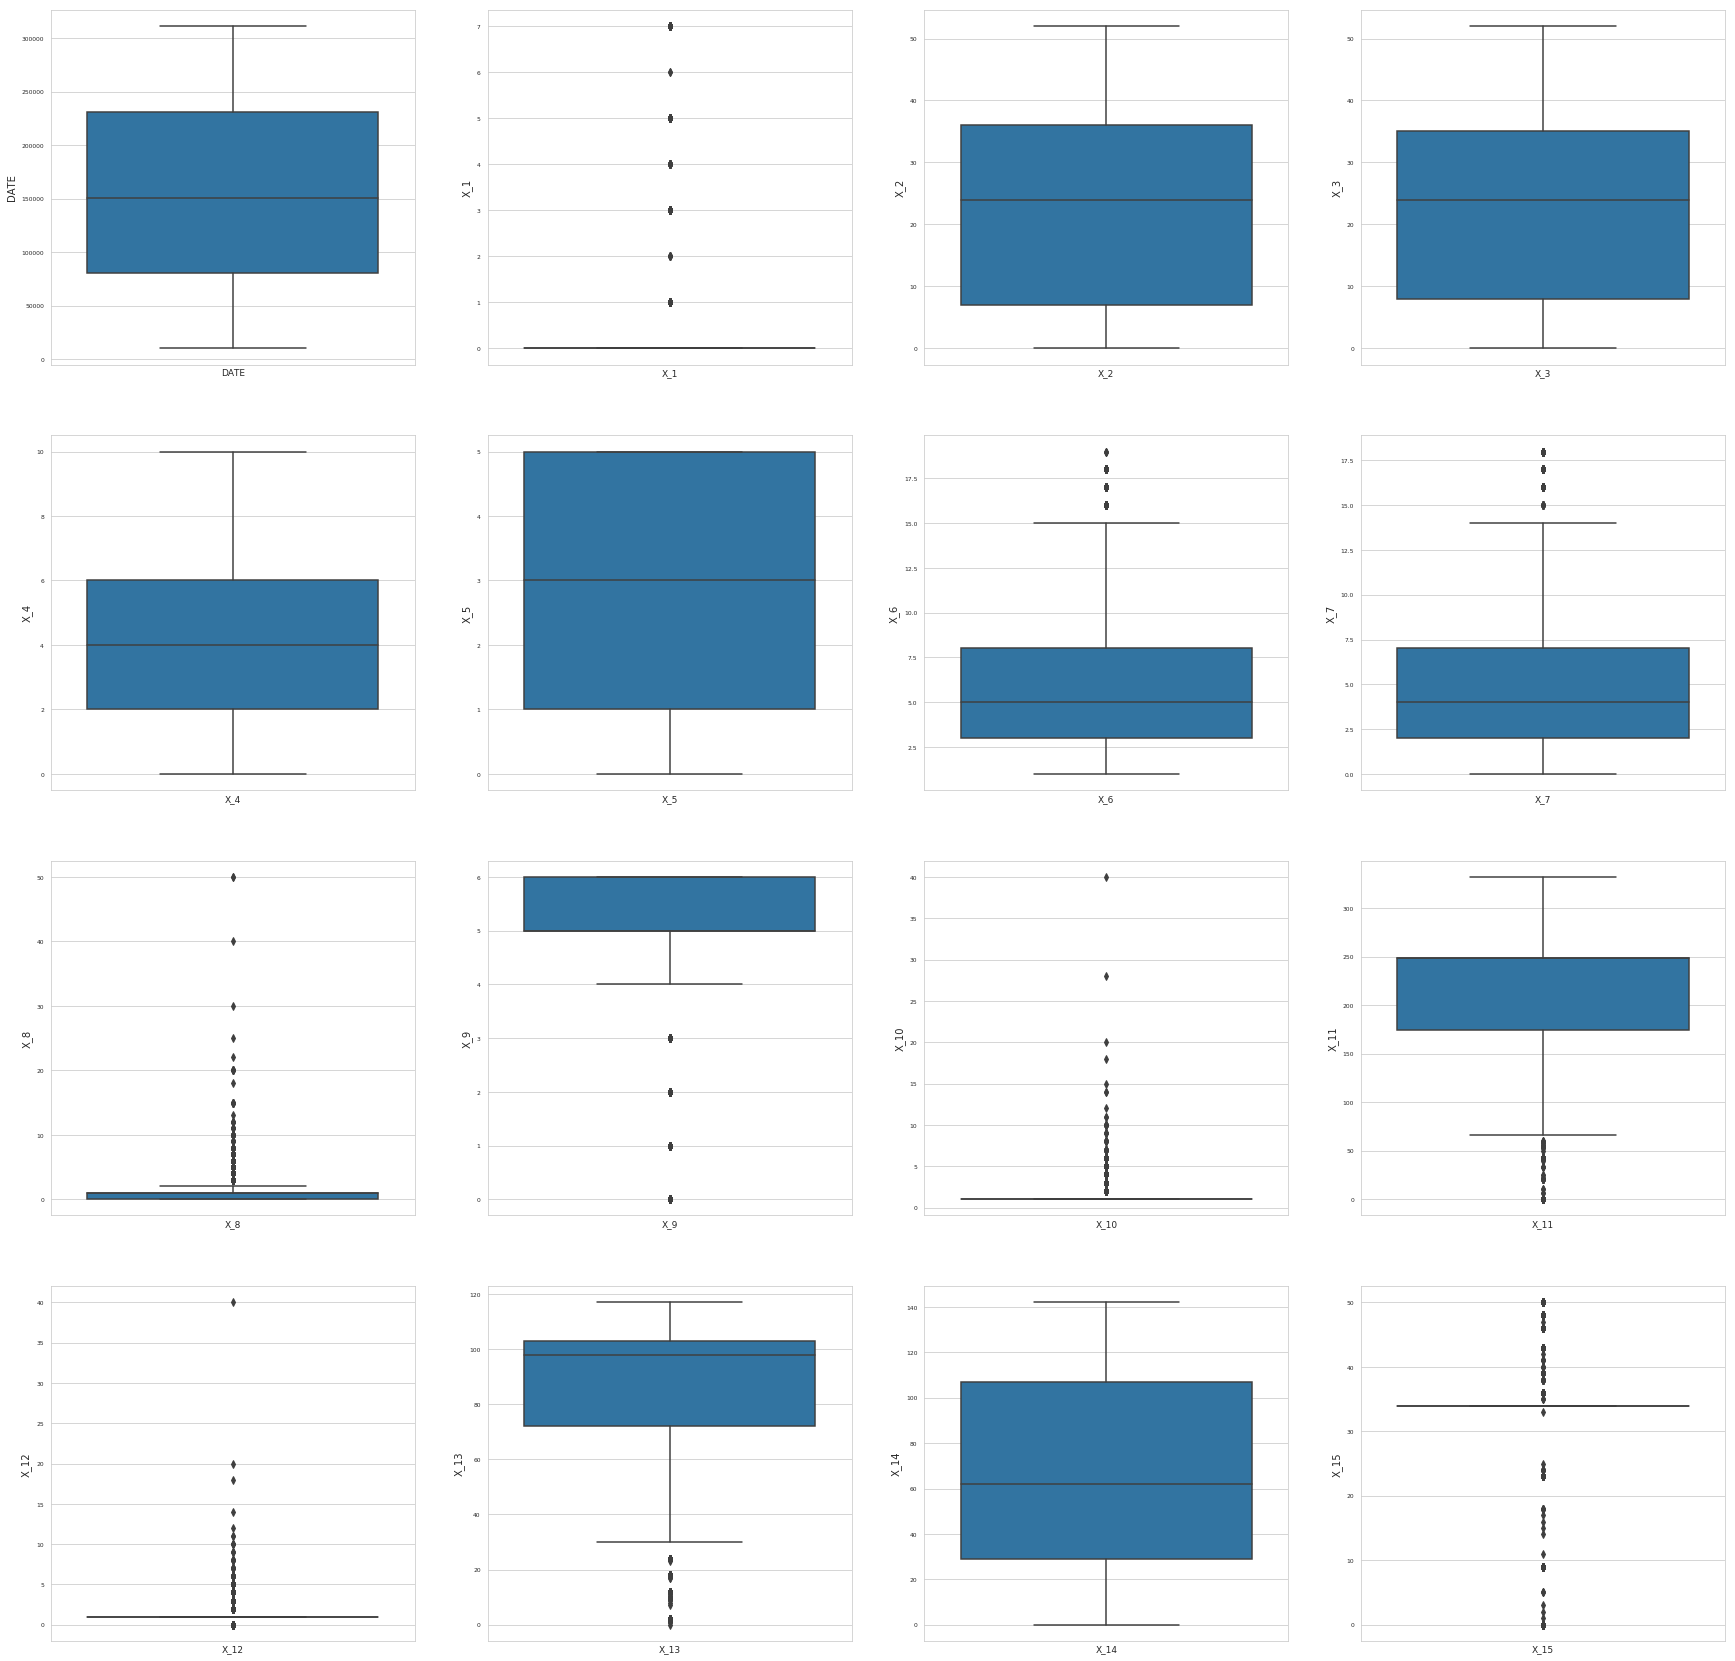

In [545]:
plot_feature_distribution(test_df, features)

* Box plot saying that there are many feature are away from upper and lower extreme.
* We can't discard those features as outliers, Since we don't know what those features are.
* Also, box plot of train and test data havign similar structures, hence we know that this are not outliers, they are just extreme values.

# Training And Evaluating Model

In [66]:
X_ = X.drop(["MULTIPLE_OFFENSE", "DATE"], axis = 1)
Y_ = X["MULTIPLE_OFFENSE"]
x_train, x_test, y_train, y_test = train_test_split(X_, Y_, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25)

In [53]:
 def boosting(x_train, y_train, x_test, y_test):
    clf = xgb.XGBClassifier(n_estimators = 2000, max_depth = 3, learning_rate = 0.3)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    print(classification_report(y_test, pred))
    print(accuracy_score(y_test, pred))
    print(recall_score(y_test, pred, pos_label = 1))
    print(recall_score(y_test, pred, pos_label = 0))
    return clf
clf_boost = boosting(x_train, y_train, x_val, y_val)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5190
           1       1.00      1.00      1.00      5063

    accuracy                           1.00     10253
   macro avg       1.00      1.00      1.00     10253
weighted avg       1.00      1.00      1.00     10253

0.9991222081342046
0.9992099545723879
0.9990366088631984


In [54]:
clf_boost.score(x_test, y_test, )

1.0

In [68]:
# def catboost(x_train, y_train, x_test, y_test):
clf = CatBoostClassifier(iterations=1000, depth = 10,  learning_rate=0.1, model_size_reg=0, random_seed=42) #loss_function='CrossEntropy')
cat_boost = clf.fit(x_train, y_train, 
        cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
        eval_set=(x_val, y_val)
        )

0:	learn: 0.4304011	test: 0.4280129	best: 0.4280129 (0)	total: 210ms	remaining: 3m 29s
1:	learn: 0.2742441	test: 0.2687365	best: 0.2687365 (1)	total: 406ms	remaining: 3m 22s
2:	learn: 0.1755623	test: 0.1711600	best: 0.1711600 (2)	total: 617ms	remaining: 3m 25s
3:	learn: 0.1163162	test: 0.1122031	best: 0.1122031 (3)	total: 817ms	remaining: 3m 23s
4:	learn: 0.0802220	test: 0.0763467	best: 0.0763467 (4)	total: 1.01s	remaining: 3m 21s
5:	learn: 0.0557822	test: 0.0524218	best: 0.0524218 (5)	total: 1.2s	remaining: 3m 18s
6:	learn: 0.0414235	test: 0.0385392	best: 0.0385392 (6)	total: 1.37s	remaining: 3m 14s
7:	learn: 0.0315104	test: 0.0288935	best: 0.0288935 (7)	total: 1.57s	remaining: 3m 14s
8:	learn: 0.0252116	test: 0.0232509	best: 0.0232509 (8)	total: 1.76s	remaining: 3m 14s
9:	learn: 0.0215568	test: 0.0198368	best: 0.0198368 (9)	total: 1.98s	remaining: 3m 15s
10:	learn: 0.0183513	test: 0.0170738	best: 0.0170738 (10)	total: 2.17s	remaining: 3m 14s
11:	learn: 0.0155701	test: 0.0144276	best:

94:	learn: 0.0017430	test: 0.0029117	best: 0.0029117 (94)	total: 17.1s	remaining: 2m 43s
95:	learn: 0.0017430	test: 0.0029117	best: 0.0029117 (95)	total: 17.3s	remaining: 2m 42s
96:	learn: 0.0017331	test: 0.0029063	best: 0.0029063 (96)	total: 17.5s	remaining: 2m 42s
97:	learn: 0.0017331	test: 0.0029063	best: 0.0029063 (97)	total: 17.5s	remaining: 2m 40s
98:	learn: 0.0017331	test: 0.0029062	best: 0.0029062 (98)	total: 17.6s	remaining: 2m 40s
99:	learn: 0.0017331	test: 0.0029063	best: 0.0029062 (98)	total: 17.7s	remaining: 2m 39s
100:	learn: 0.0016948	test: 0.0028767	best: 0.0028767 (100)	total: 17.9s	remaining: 2m 38s
101:	learn: 0.0016947	test: 0.0028767	best: 0.0028767 (101)	total: 18s	remaining: 2m 38s
102:	learn: 0.0016947	test: 0.0028767	best: 0.0028767 (102)	total: 18.1s	remaining: 2m 38s
103:	learn: 0.0016237	test: 0.0028289	best: 0.0028289 (103)	total: 18.4s	remaining: 2m 38s
104:	learn: 0.0016236	test: 0.0028289	best: 0.0028289 (103)	total: 18.5s	remaining: 2m 37s
105:	learn: 0

186:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 33.8s	remaining: 2m 26s
187:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 34s	remaining: 2m 26s
188:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 34.1s	remaining: 2m 26s
189:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 34.3s	remaining: 2m 26s
190:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 34.4s	remaining: 2m 25s
191:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 34.6s	remaining: 2m 25s
192:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 34.7s	remaining: 2m 25s
193:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 34.9s	remaining: 2m 25s
194:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 35.2s	remaining: 2m 25s
195:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 35.4s	remaining: 2m 25s
196:	learn: 0.0014426	test: 0.0027522	best: 0.0027463 (148)	total: 35.8s	remaining: 2m 25s
1

277:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 51.5s	remaining: 2m 13s
278:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 51.7s	remaining: 2m 13s
279:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 51.8s	remaining: 2m 13s
280:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 52s	remaining: 2m 13s
281:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 52.2s	remaining: 2m 12s
282:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 52.4s	remaining: 2m 12s
283:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 52.6s	remaining: 2m 12s
284:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 52.9s	remaining: 2m 12s
285:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 53.2s	remaining: 2m 12s
286:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 53.4s	remaining: 2m 12s
287:	learn: 0.0014418	test: 0.0027518	best: 0.0027463 (148)	total: 53.6s	remaining: 2m 12s
2

369:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 9s	remaining: 1m 57s
370:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 9s	remaining: 1m 57s
371:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 9s	remaining: 1m 57s
372:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 9s	remaining: 1m 56s
373:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 9s	remaining: 1m 56s
374:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 9s	remaining: 1m 56s
375:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 10s	remaining: 1m 56s
376:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 10s	remaining: 1m 56s
377:	learn: 0.0014414	test: 0.0027516	best: 0.0027463 (148)	total: 1m 10s	remaining: 1m 55s
378:	learn: 0.0014413	test: 0.0027516	best: 0.0027463 (148)	total: 1m 10s	remaining: 1m 55s
379:	learn: 0.0014413	test: 0.0027516	best: 0.0027463 (148)	total: 1m 10s	remaining: 1

460:	learn: 0.0014411	test: 0.0027516	best: 0.0027463 (148)	total: 1m 24s	remaining: 1m 38s
461:	learn: 0.0014411	test: 0.0027516	best: 0.0027463 (148)	total: 1m 24s	remaining: 1m 38s
462:	learn: 0.0014411	test: 0.0027516	best: 0.0027463 (148)	total: 1m 24s	remaining: 1m 38s
463:	learn: 0.0014411	test: 0.0027516	best: 0.0027463 (148)	total: 1m 25s	remaining: 1m 38s
464:	learn: 0.0014411	test: 0.0027516	best: 0.0027463 (148)	total: 1m 25s	remaining: 1m 38s
465:	learn: 0.0014411	test: 0.0027516	best: 0.0027463 (148)	total: 1m 25s	remaining: 1m 37s
466:	learn: 0.0014410	test: 0.0027516	best: 0.0027463 (148)	total: 1m 25s	remaining: 1m 37s
467:	learn: 0.0014410	test: 0.0027516	best: 0.0027463 (148)	total: 1m 25s	remaining: 1m 37s
468:	learn: 0.0014410	test: 0.0027516	best: 0.0027463 (148)	total: 1m 25s	remaining: 1m 37s
469:	learn: 0.0014410	test: 0.0027516	best: 0.0027463 (148)	total: 1m 26s	remaining: 1m 37s
470:	learn: 0.0014410	test: 0.0027516	best: 0.0027463 (148)	total: 1m 26s	remain

550:	learn: 0.0014405	test: 0.0027517	best: 0.0027463 (148)	total: 1m 45s	remaining: 1m 25s
551:	learn: 0.0014405	test: 0.0027517	best: 0.0027463 (148)	total: 1m 45s	remaining: 1m 25s
552:	learn: 0.0014405	test: 0.0027517	best: 0.0027463 (148)	total: 1m 45s	remaining: 1m 25s
553:	learn: 0.0014405	test: 0.0027517	best: 0.0027463 (148)	total: 1m 45s	remaining: 1m 25s
554:	learn: 0.0014405	test: 0.0027517	best: 0.0027463 (148)	total: 1m 46s	remaining: 1m 25s
555:	learn: 0.0014405	test: 0.0027517	best: 0.0027463 (148)	total: 1m 46s	remaining: 1m 24s
556:	learn: 0.0014405	test: 0.0027518	best: 0.0027463 (148)	total: 1m 46s	remaining: 1m 24s
557:	learn: 0.0014405	test: 0.0027518	best: 0.0027463 (148)	total: 1m 46s	remaining: 1m 24s
558:	learn: 0.0014405	test: 0.0027518	best: 0.0027463 (148)	total: 1m 47s	remaining: 1m 24s
559:	learn: 0.0014405	test: 0.0027518	best: 0.0027463 (148)	total: 1m 47s	remaining: 1m 24s
560:	learn: 0.0014405	test: 0.0027518	best: 0.0027463 (148)	total: 1m 47s	remain

640:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 4s	remaining: 1m 9s
641:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 4s	remaining: 1m 9s
642:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 4s	remaining: 1m 9s
643:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 5s	remaining: 1m 9s
644:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 5s	remaining: 1m 8s
645:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 5s	remaining: 1m 8s
646:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 5s	remaining: 1m 8s
647:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 5s	remaining: 1m 8s
648:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 6s	remaining: 1m 8s
649:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 6s	remaining: 1m 8s
650:	learn: 0.0014402	test: 0.0027520	best: 0.0027463 (148)	total: 2m 6s	remaining: 1m 7s
651:	learn

731:	learn: 0.0014397	test: 0.0027519	best: 0.0027463 (148)	total: 2m 21s	remaining: 51.8s
732:	learn: 0.0014397	test: 0.0027519	best: 0.0027463 (148)	total: 2m 21s	remaining: 51.7s
733:	learn: 0.0014397	test: 0.0027519	best: 0.0027463 (148)	total: 2m 22s	remaining: 51.5s
734:	learn: 0.0014397	test: 0.0027520	best: 0.0027463 (148)	total: 2m 22s	remaining: 51.3s
735:	learn: 0.0014397	test: 0.0027520	best: 0.0027463 (148)	total: 2m 22s	remaining: 51.1s
736:	learn: 0.0014397	test: 0.0027520	best: 0.0027463 (148)	total: 2m 22s	remaining: 50.9s
737:	learn: 0.0014397	test: 0.0027520	best: 0.0027463 (148)	total: 2m 22s	remaining: 50.7s
738:	learn: 0.0014397	test: 0.0027520	best: 0.0027463 (148)	total: 2m 23s	remaining: 50.6s
739:	learn: 0.0014397	test: 0.0027520	best: 0.0027463 (148)	total: 2m 23s	remaining: 50.4s
740:	learn: 0.0014397	test: 0.0027520	best: 0.0027463 (148)	total: 2m 23s	remaining: 50.2s
741:	learn: 0.0014397	test: 0.0027520	best: 0.0027463 (148)	total: 2m 23s	remaining: 50s
7

822:	learn: 0.0014394	test: 0.0027521	best: 0.0027463 (148)	total: 2m 41s	remaining: 34.7s
823:	learn: 0.0014394	test: 0.0027521	best: 0.0027463 (148)	total: 2m 41s	remaining: 34.5s
824:	learn: 0.0014394	test: 0.0027521	best: 0.0027463 (148)	total: 2m 41s	remaining: 34.3s
825:	learn: 0.0014394	test: 0.0027521	best: 0.0027463 (148)	total: 2m 42s	remaining: 34.1s
826:	learn: 0.0014394	test: 0.0027521	best: 0.0027463 (148)	total: 2m 42s	remaining: 33.9s
827:	learn: 0.0014393	test: 0.0027521	best: 0.0027463 (148)	total: 2m 42s	remaining: 33.7s
828:	learn: 0.0014393	test: 0.0027521	best: 0.0027463 (148)	total: 2m 42s	remaining: 33.5s
829:	learn: 0.0014393	test: 0.0027521	best: 0.0027463 (148)	total: 2m 42s	remaining: 33.3s
830:	learn: 0.0014393	test: 0.0027521	best: 0.0027463 (148)	total: 2m 42s	remaining: 33.1s
831:	learn: 0.0014393	test: 0.0027521	best: 0.0027463 (148)	total: 2m 43s	remaining: 32.9s
832:	learn: 0.0014393	test: 0.0027521	best: 0.0027463 (148)	total: 2m 43s	remaining: 32.7s

913:	learn: 0.0014392	test: 0.0027523	best: 0.0027463 (148)	total: 2m 57s	remaining: 16.7s
914:	learn: 0.0014392	test: 0.0027523	best: 0.0027463 (148)	total: 2m 57s	remaining: 16.5s
915:	learn: 0.0014392	test: 0.0027523	best: 0.0027463 (148)	total: 2m 57s	remaining: 16.3s
916:	learn: 0.0014392	test: 0.0027523	best: 0.0027463 (148)	total: 2m 58s	remaining: 16.1s
917:	learn: 0.0014391	test: 0.0027523	best: 0.0027463 (148)	total: 2m 58s	remaining: 15.9s
918:	learn: 0.0014391	test: 0.0027523	best: 0.0027463 (148)	total: 2m 58s	remaining: 15.7s
919:	learn: 0.0014391	test: 0.0027523	best: 0.0027463 (148)	total: 2m 58s	remaining: 15.5s
920:	learn: 0.0014391	test: 0.0027523	best: 0.0027463 (148)	total: 2m 58s	remaining: 15.3s
921:	learn: 0.0014391	test: 0.0027523	best: 0.0027463 (148)	total: 2m 59s	remaining: 15.2s
922:	learn: 0.0014391	test: 0.0027523	best: 0.0027463 (148)	total: 2m 59s	remaining: 15s
923:	learn: 0.0014391	test: 0.0027523	best: 0.0027463 (148)	total: 2m 59s	remaining: 14.8s
9

In [69]:
cat_boost.score(x_test, y_test)

0.9993416721527321

In [47]:
cat_boost.feature_importances_

array([ 1.38647578,  0.75221319,  4.97749221,  4.81418814,  6.78995439,
        5.10423464,  3.28075584,  3.23556235,  0.8266907 ,  1.19502656,
       16.52199797, 28.07855032, 12.32835642,  0.58919363,  0.5431463 ,
        9.57616155])

In [548]:
clf_boost.fit(X_, Y_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
feature_imp = sorted(zip(cat_boost.feature_importances_, x_train.columns), reverse = True)
for col, feat in feature_imp:
    print(feat,":", col)

X_11 : 28.078550320471166
X_10 : 16.52199797131996
X_12 : 12.32835641723502
X_15 : 9.576161553879848
X_4 : 6.7899543894781
X_5 : 5.104234639136661
X_2 : 4.9774922133824235
X_3 : 4.814188144095364
X_6 : 3.2807558359271973
X_7 : 3.2355623505711835
DATE : 1.3864757767786757
X_9 : 1.1950265610343482
X_8 : 0.8266907047335077
X_1 : 0.7522131898872149
X_13 : 0.589193629682358
X_14 : 0.543146302387055


* Data is having numerical features, Random forest and Gradient Boosted methods will handle this features much effectively than other alorithms. And these are much more interpretable. Also I trained with SVM using Linear kernel and RBF kernel by standerdizing features, it's not giving good accuracy as gradient boosting and random forest does. Among Gradeint boosting and Random forest got good recall score with Gradient Boosting. 

* Tuned the Hypermeters several times to get optimal hyper parameters using Grid Search for SVM, Random Forest and Gradient Boosting

* we can't ignore the data which is far from mean without knowing what are those features. I used Z-score(var > 3) and IQR to detect outliers and removed outliers and observed that there is a performance drop when i am removing outliers. 

* Both test and train data features have similar kind of distributions and spread, So we have to consider the data which is far from mean, and they will contribute something to our Algorithm to make better predictions.

* We got best recall score for Gradient Boosted Classifier 
                * for label 1 we got recall score of 99.82
                * for label 0 we got recall score of 99.82
* Interpretation:
        * X_10, X_11, X_12 features are very important features. 


# Saving Results

In [550]:
test_data = test_df.drop(["INCIDENT_ID"],axis = 1)
predictions = clf_boost.predict(test_data)
out_data = {"INCIDENT_ID": test_df["INCIDENT_ID"], "MULTIPLE_OFFENSE": predictions}
results_df = pd.DataFrame(out_data, columns =["INCIDENT_ID", "MULTIPLE_OFFENSE"])
results_df.to_csv("predictions.csv", index = False)